<h1>Audio Applications</h1><BR>
Now that we have established the theory behind the geometry of 1D time series sliding window embeddings, we will look at our first real applications: audio signals.  First, we will import all of the necessary libraries and define the sliding window code as before.  
<BR><i>We also take this as an opportunity to acknowledge the <a href = "http://librosa.github.io/librosa/">librosa library</a> for audio processing in Python.</i>

In [1]:
##Do all of the imports and setup inline plotting
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import scipy.interpolate as interp

from TDA import *
import scipy.io.wavfile
import librosa

##Setup the sliding window code
def getSlidingWindow(x, dim, Tau, dT):
    N = len(x)
    NWindows = int(np.floor((N-dim*Tau)/dT)) #The number of windows
    if NWindows <= 0:
        print("Error: Tau too large for signal extent")
        return np.zeros((3, dim))
    X = np.zeros((NWindows, dim)) #Create a 2D array which will store all windows
    idx = np.arange(N)
    for i in range(NWindows):
        #Figure out the indices of the samples in this window
        idxx = dT*i + Tau*np.arange(dim) 
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))+2
        if end >= len(x):
            X = X[0:i, :]
            break
        #Do spline interpolation to fill in this window, and place
        #it in the resulting array
        X[i, :] = interp.spline(idx[start:end+1], x[start:end+1], idxx)
    return X

<h1>Biphonation Overview</h1>

Biphonation refers to the presence of two or more simultaneous frequencies in a signal which are "incommensurate"; that is, their frequencies are linearly independent over the rational numbers.  In other words, the frequencies are "inharmonic."  We saw a synthetic example in class 1 of cos(x) + cos(pi x).  Today, we will examine how this manifests itself in biology with horse whinnies that occur during states of high emotional valence.  During the steady state of a horse whinnie, biphonation is found

<table>
<tr><td>
<img src = "Whinnie.png">
</td></tr>
<tr><td>
<b>Figure 1</b>: Audio of a horse whinnie.  Courtesy of <a href = "http://www.nature.com/articles/srep09989#s1">http://www.nature.com/articles/srep09989#s1</a></td></tr>
</table>

<!--<iframe width="560" height="315" src="https://www.youtube.com/embed/f8DdGpHkzu4" frameborder="0" allowfullscreen></iframe>!-->
<BR><BR>
<h1>Biphonation Example with Horse Whinnies</h1><BR>

Let's now load the audio from the horse whinnie example, interactively plot the audio waveform, and listen to it.


<IPython.core.display.Javascript object>


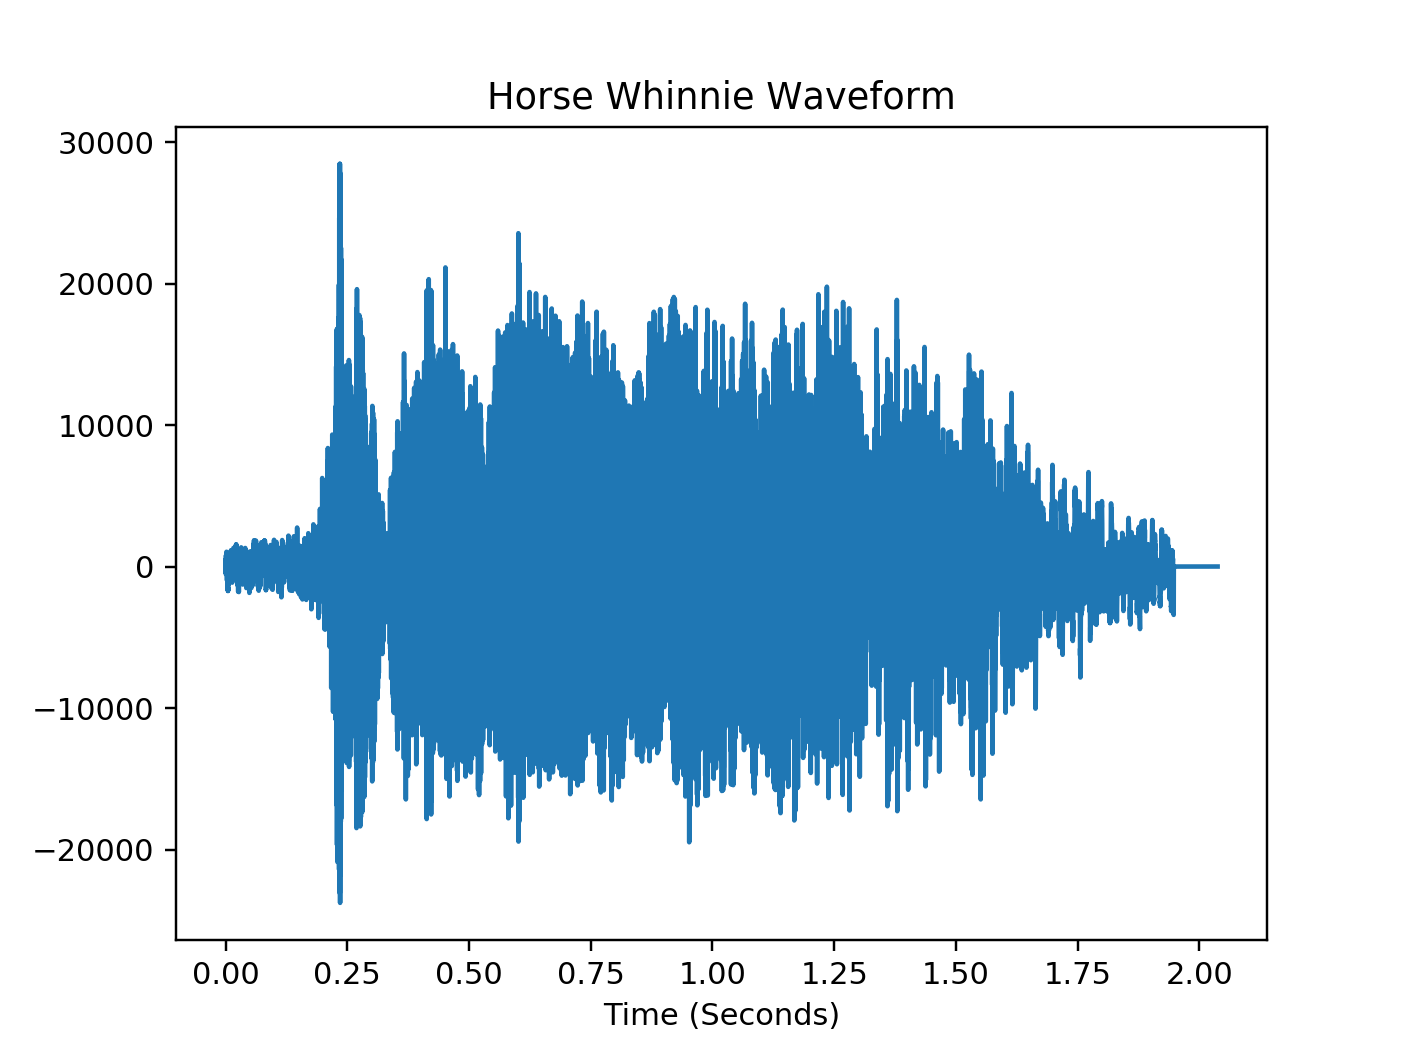

<IPython.core.display.Javascript object>


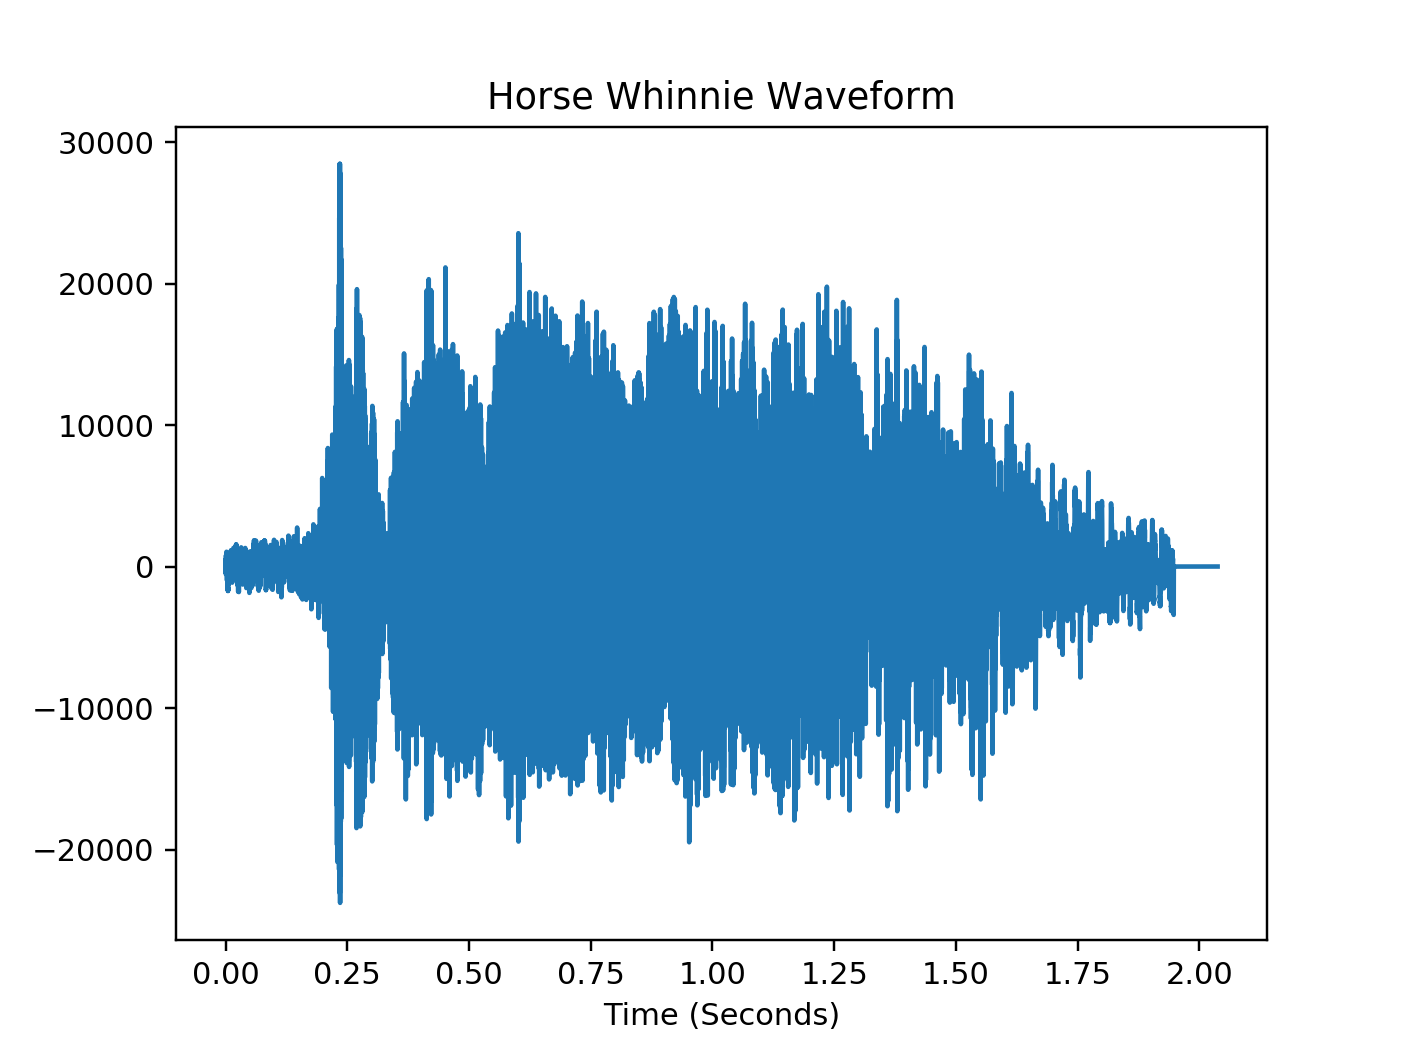

In [7]:
#Read in the audio file.  Fs is the sample rate, and
#X is the audio signal
Fs, X = scipy.io.wavfile.read("horsewhinnie.wav")
plt.figure()
plt.plot(np.arange(len(X))/float(Fs), X)
plt.xlabel("Time (Seconds)")
plt.title("Horse Whinnie Waveform")
plt.show()

from IPython.display import Audio
# load a remote WAV file
Audio('horsewhinnie.wav')

The code below will extract a subsection of the signal and perform a sliding window embedding + 1D persistent homology.  Using the interactive plot of the audio waveform above, find two different time ranges to plot:<BR>

<ol>
<li>A region with a pure tone (single sinusoid), which can be found towards the beginning</li>
<li>A region with biphonation, which can be found towards the middle.  Ensure that this region has two strongly persistent classes with early birth times.  The class will compete to find the region which shows biphonation the most clearly with these statistics, and the score will be based on the <i>second largest persistence</i>, which will be indicated in the persistence diagram plot<BR></li>
</ol>
To interactively search for regions, use the pan icon
<img src = "PanIcon.png">
then left click and drag to translate, and right click and drag to zoom.  Once you've found a region, modify the "time" variable in the code below accordingly, and run it.

In [3]:
#These variables are used to adjust the window size
F0 = 493 #First fundamental frequency
G0 = 1433 #Second fundamental frequency

###TODO: Modify this variable (time in seconds)
time = 0

#Step 1: Extract an audio snippet starting at the chosen time
SigLen = 512 #The number of samples to take after the start time
iStart = int(round(time*Fs))
x = X[iStart:iStart + SigLen]
W = int(round(Fs/G0))

#Step 2: Get the sliding window embedding
Y = getSlidingWindow(x, W, 2, 2)
#Mean-center and normalize
Y = Y - np.mean(Y, 1)[:, None]
Y = Y/np.sqrt(np.sum(Y**2, 1))[:, None]

#Step 3: Do the 1D rips filtration
PDs = doRipsFiltration(Y, 1)
PD = PDs[1]

#Step 4: Figure out the second largest persistence
sP = 0
sPIdx = 0
if PD.shape[0] > 1:
    Pers = PD[:, 1] - PD[:, 0]
    sPIdx = np.argsort(-Pers)[1]
    sP = Pers[sPIdx]
    
#Step 5: Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Starting At %g Seconds"%time)
plt.plot(time + np.arange(SigLen)/Fs, x)
plt.xlabel("Time")
plt.subplot(122)
plotDGM(PD)
plt.hold(True)
plt.plot([PD[sPIdx, 0]]*2, PD[sPIdx, :], 'r')
plt.scatter(PD[sPIdx, 0], PD[sPIdx, 1], 20, 'r')
plt.title("Second Largest Persistence: %g"%sP)

/usr/lib/python3/dist-packages/ipykernel/__main__.py:31: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/ipykernel/__main__.py:40: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/lib/python3/dist-packages/matplotlib/__init__.py:919: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/lib/python3/dist-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


<h1>Music Analysis</h1>

<img src = "journey.jpg"><BR><BR>

Music is full of repetition.  For instance, there is usually a hierarchy of rhythm which determines how the music "pulses," or repeates itself in beat patterns.  Often, a dominant rhythm level is deemed the "tempo" of the music.  Typical tempos range from about 50 beats per minute to 200 beats per minute.  Let's take a moderate tempo level of 120 beats per minute, for instance, which occurs in the song "Don't Stop Believin'" by Journey.  This corresponds to a period of 0.5 seconds.  As we saw in the horse example, sound is sampled at 44100 samples per second.  This corresponds to an ideal sliding window interval length of 22050.  Let's try to compute the sliding window embedding of the raw audio to see if the tempo manifests itself with TDA.  First, we will load in "Don't Stop Believing" below:

<IPython.core.display.Javascript object>


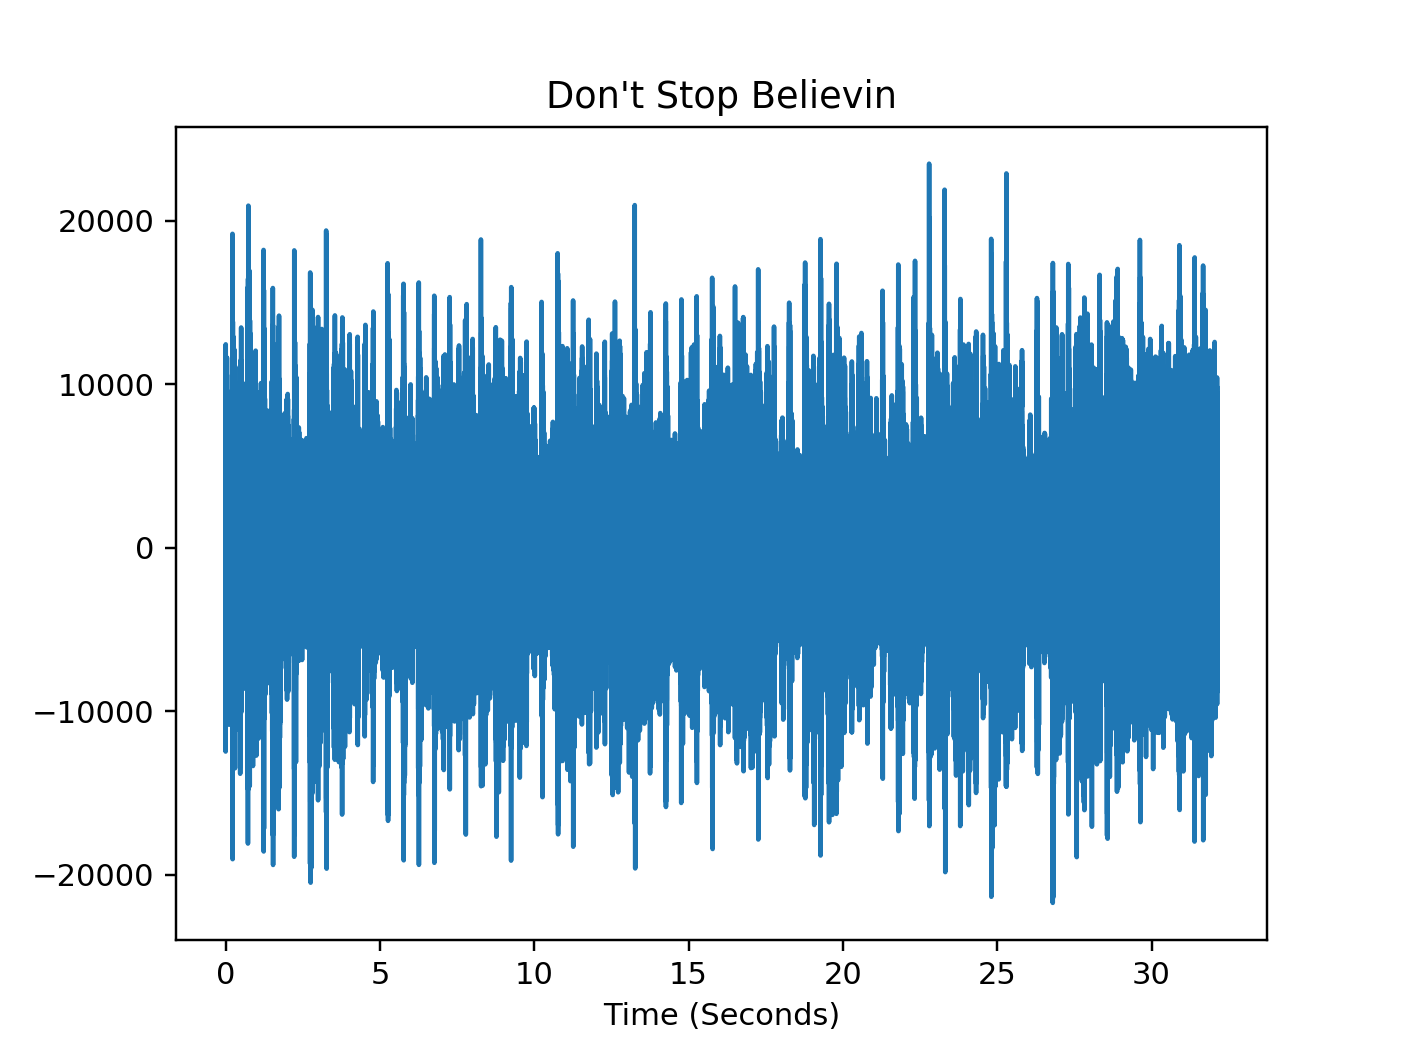

<IPython.core.display.Javascript object>


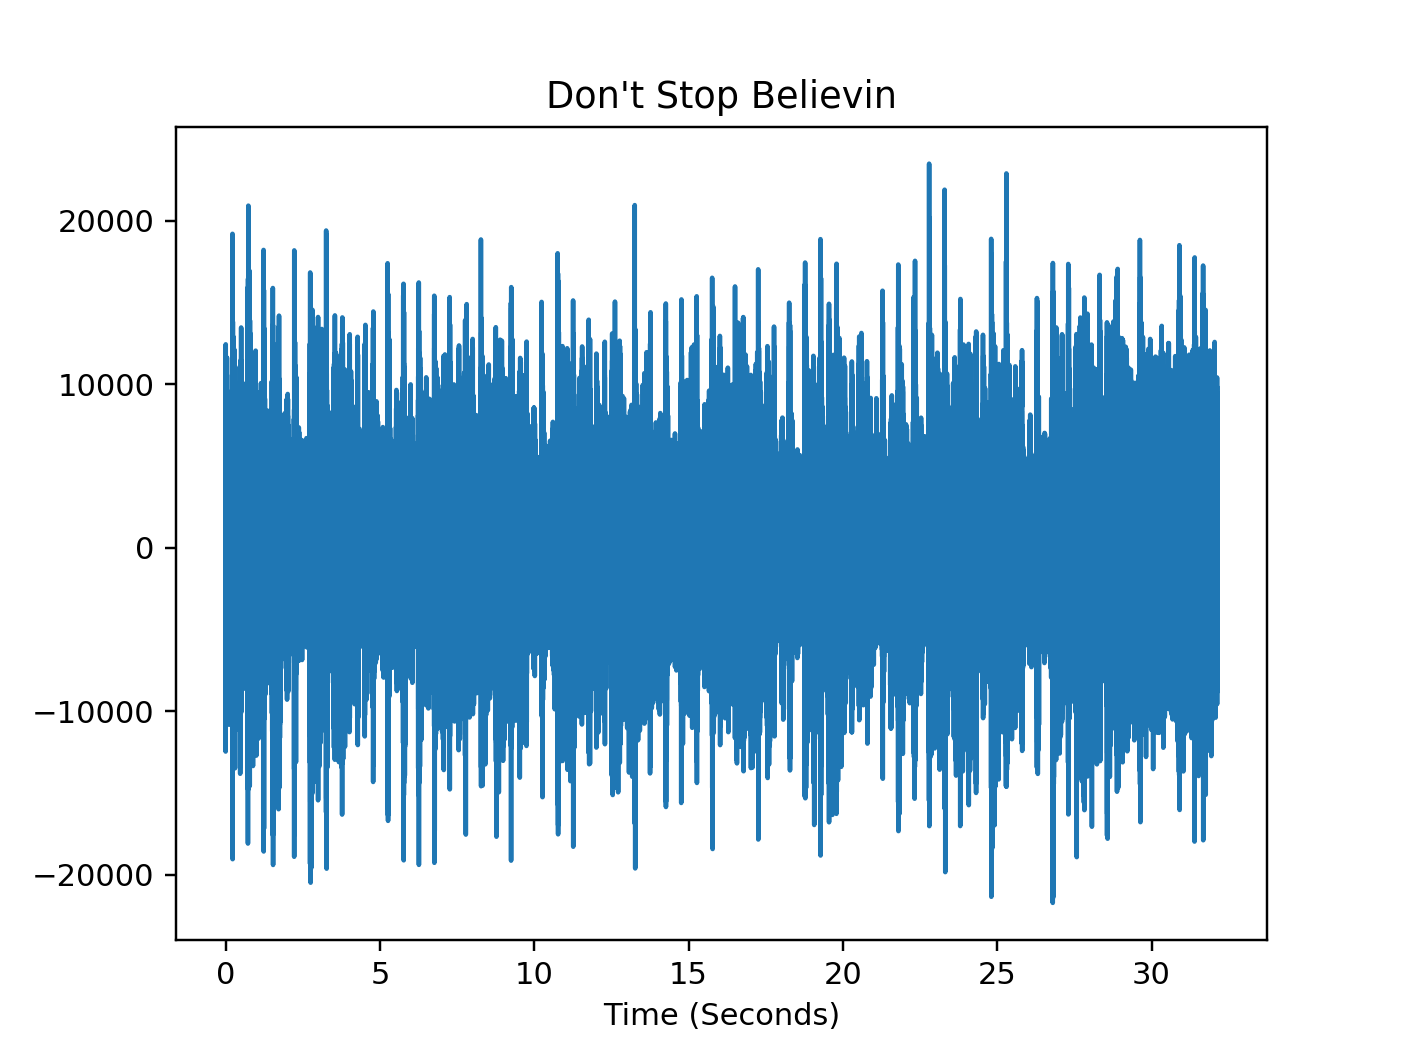

In [8]:
Fs, X = scipy.io.wavfile.read("journey.wav") #Don't Stop Believing
plt.figure()
plt.plot(np.arange(len(X))/float(Fs), X)
plt.xlabel("Time (Seconds)")
plt.title("Don't Stop Believin")
plt.show()

Audio('journey.wav')

<BR><BR>
Now let's do a sliding window with a window length equal to the sample rate over 2, corresponding to the fact that a beat period is a half of a second in this song.  We will have to have a large <code>Tau</code> and <code>dT</code>, since there is such a high sampling rate, because otherwise the TDA code will grind to a halt with way too many points.  We will also need to set up special sliding window code that skips the spline interpolation step, because this will also be prohibitively slow at this sampling rate.  In other words, we will assume that <code>Tau</code> and <code>dT</code> are integers.  Here's the code that does all of this on the first three seconds of audio:

Y.shape =  (250, 110)


<IPython.core.display.Javascript object>


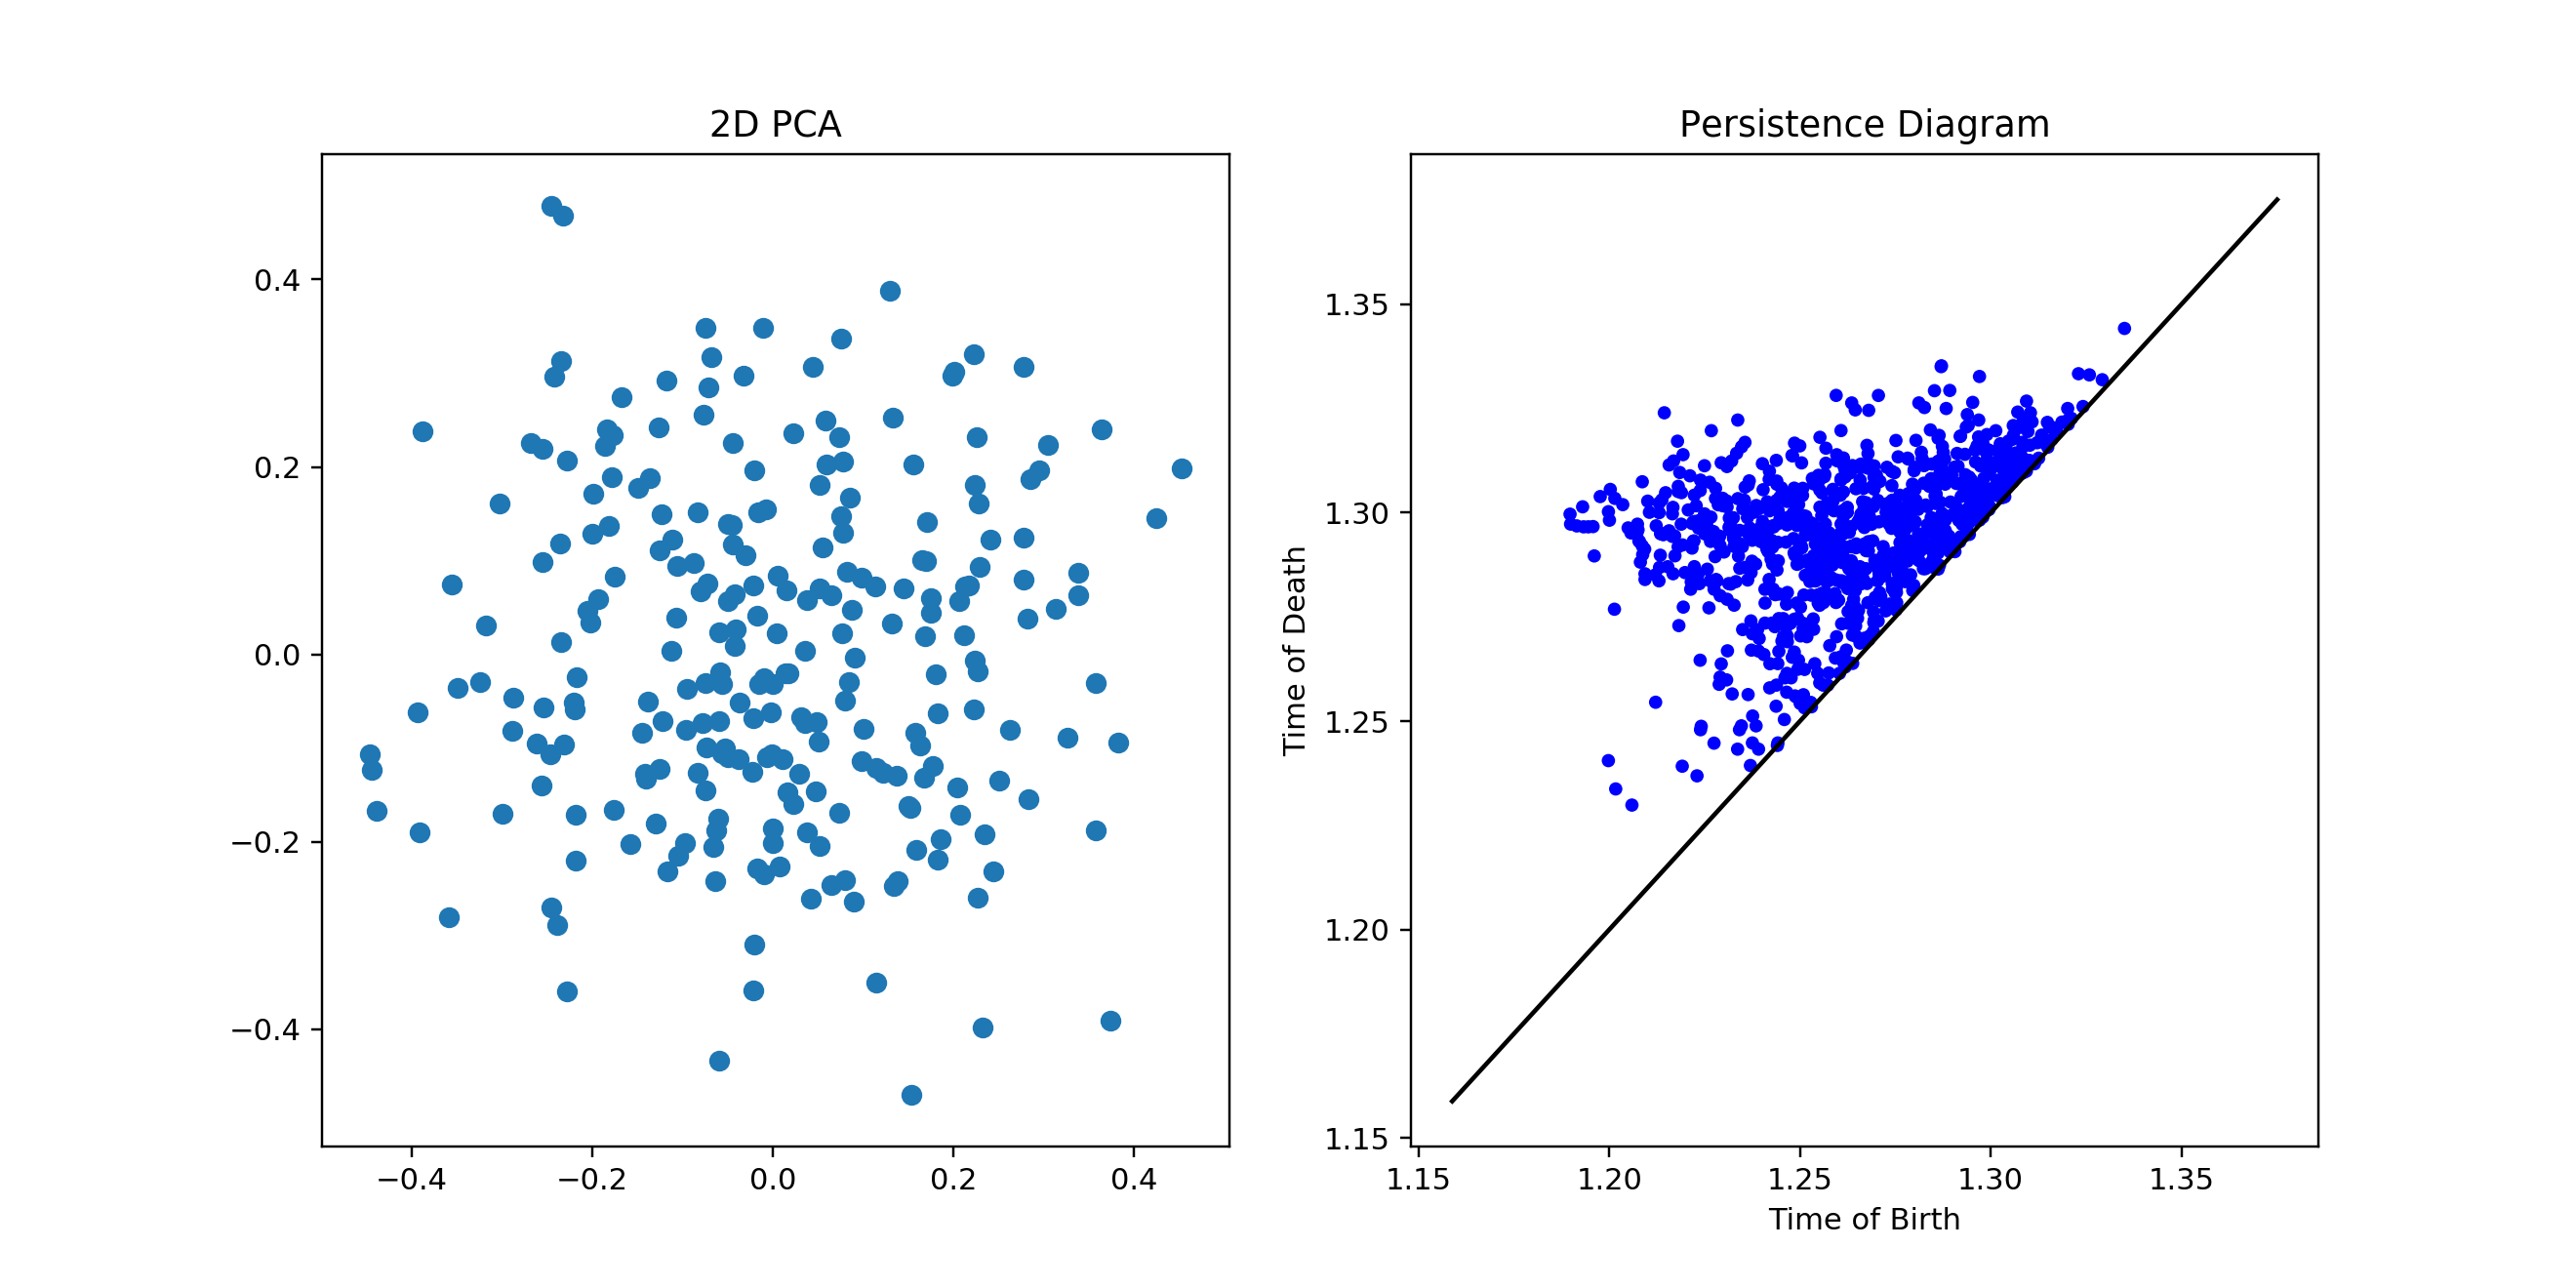

<IPython.core.display.Javascript object>


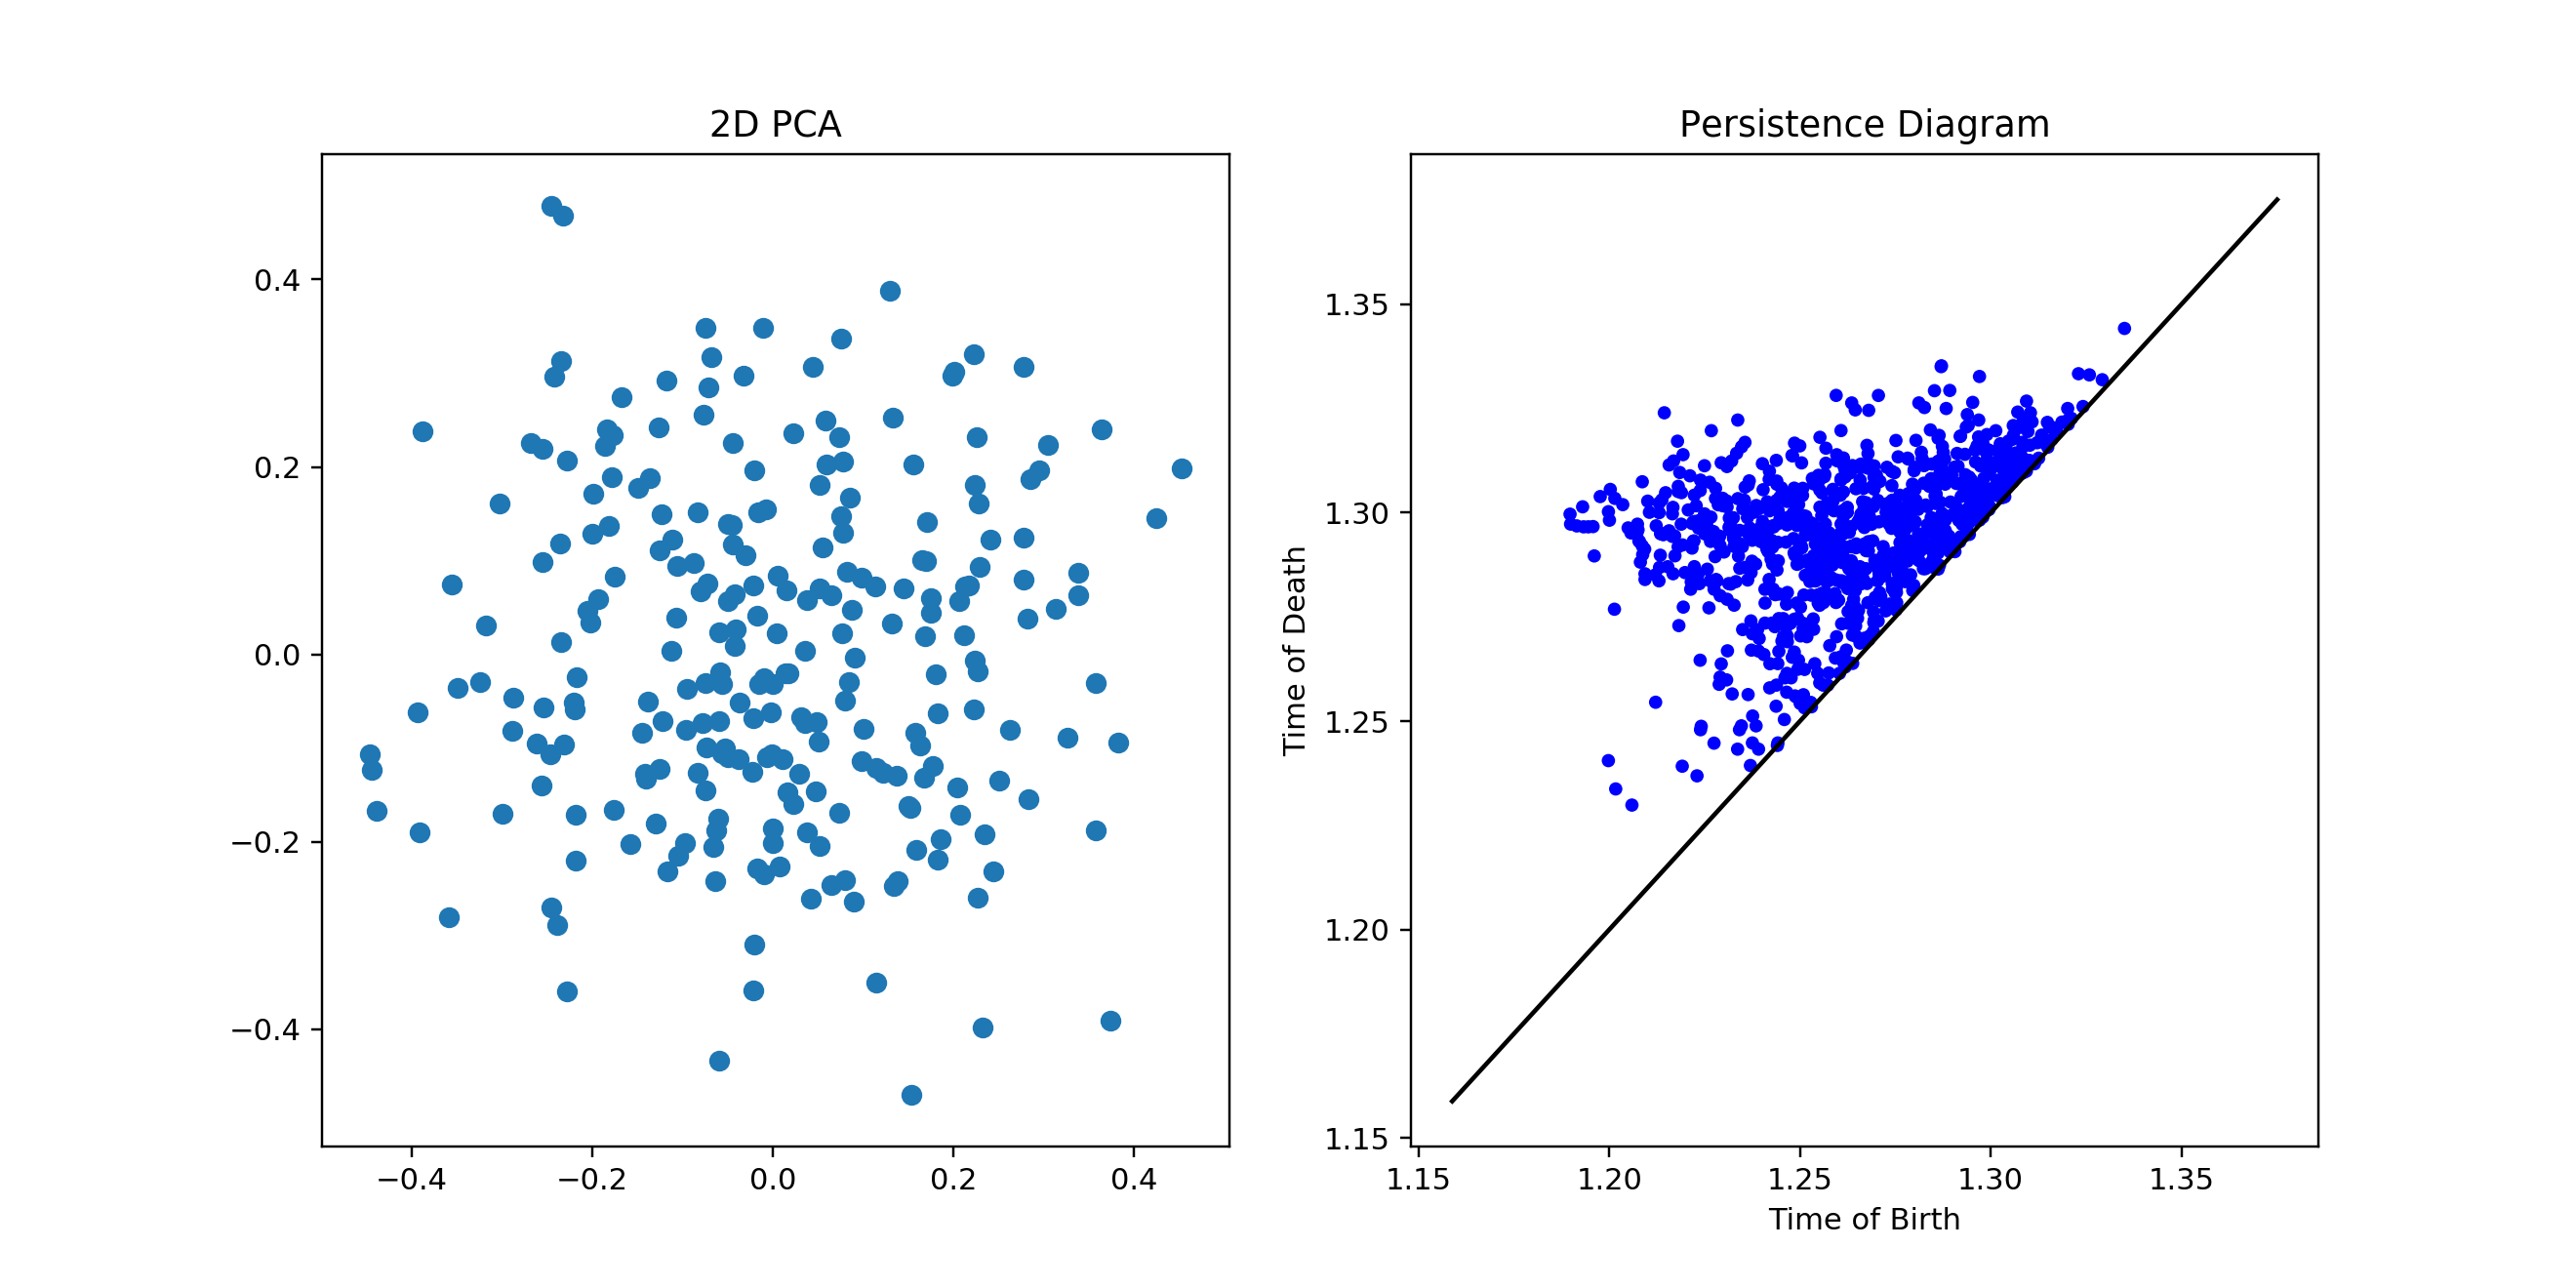

In [9]:
#Sliding window code here assumes integer x, dim, and Tau so no interpolation
#is needed (for computational efficiency)
def getSlidingWindowInteger(x, dim, Tau, dT):
    N = len(x)
    NWindows = int(np.floor((N-dim*Tau)/dT)) #The number of windows
    if NWindows <= 0:
        print("Error: Tau too large for signal extent")
        return np.zeros((3, dim))
    X = np.zeros((NWindows, dim)) #Create a 2D array which will store all windows
    idx = np.arange(N)
    for i in range(NWindows):
        #Figure out the indices of the samples in this window
        idxx = np.array(dT*i + Tau*np.arange(dim), dtype=np.int32)
        X[i, :] = x[idxx]
    return X


#Note that dim*Tau here spans a half a second of audio, 
#since Fs is the sample rate
dim = round(Fs/200)
Tau = 100
dT = Fs/100
Y = getSlidingWindowInteger(X[0:Fs*3], dim, Tau, dT)
print("Y.shape = ", Y.shape)
#Mean-center and normalize
Y = Y - np.mean(Y, 1)[:, None]
Y = Y/np.sqrt(np.sum(Y**2, 1))[:, None]

PDs = doRipsFiltration(Y, 1)
pca = PCA()
Z = pca.fit_transform(Y)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("2D PCA")
plt.scatter(Z[:, 0], Z[:, 1])
plt.subplot(122)
plotDGM(PDs[1])
plt.title("Persistence Diagram")
plt.show()

Unfortunately, the sample rate is just to high and the signal is just too messy for this algorithm to work.  We will have to do some more sophisticated preprocessing before applying the algorithm

<h1>Audio Novelty Functions And Music vs Speech</h1>
One way to deal with the fact that music is both messy and at a high sampling rate is to derive something called the "audio novelty function," which is designed explicitly to pick up on rhythmic events.  To see how it's motivated, let's look at the <a href = "https://en.wikipedia.org/wiki/Spectrogram">audio spectrogram</a> of this song



In [10]:
#Compute the power spectrogram
D = librosa.logamplitude(np.abs(librosa.stft(X[0:Fs*3]))**2, ref_power=np.max)
librosa.display.specshow(D, y_axis='log', sr=Fs)
plt.figure()
librosa.display.specshow(D, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.show()

AttributeError: module 'librosa' has no attribute 'display'

You might notice that there are vertical streaks in a semi-periodic pattern.  These correspond to "broadband percussive events," or, on other words, likely onsets for beats when drums occur.  An audio novelty function is derived from a spectrogram by looking at the difference between successive frames to try to pick up on this.  The code below extracts the audio novelty function and displays it for the same audio snippet.

In [11]:
#Extract audio novelty function of entire song
hopSize = 256
XNov = librosa.onset.onset_strength(y = X, sr = Fs, hop_length = hopSize)

plt.figure()
#Plot the spectrogram again
plt.subplot(211)
librosa.display.specshow(D, x_axis='time', y_axis='log')
plt.title('Log-frequency power spectrogram')

#Plot the audio novelty function
plt.subplot(212)
plt.plot(np.arange(len(XNov))*hopSize/float(Fs), XNov)
plt.xlim([0, 3])
plt.xlabel("Time (Seconds)")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AttributeError: module 'librosa' has no attribute 'display'

Not only is the audio novelty function a cleaner signal, but it is also at a much lower sample rate.  Since the "hop size" between each spectrogram window is 256 samples, the temporal resolution is coarser by that factor.  
<h2>Music Audio Novelty Embedding</h2>

Let's now try our sliding window with the audio novelty function of the previous example instead of the raw audio:<BR>

Y.shape =  (215, 20)


<IPython.core.display.Javascript object>


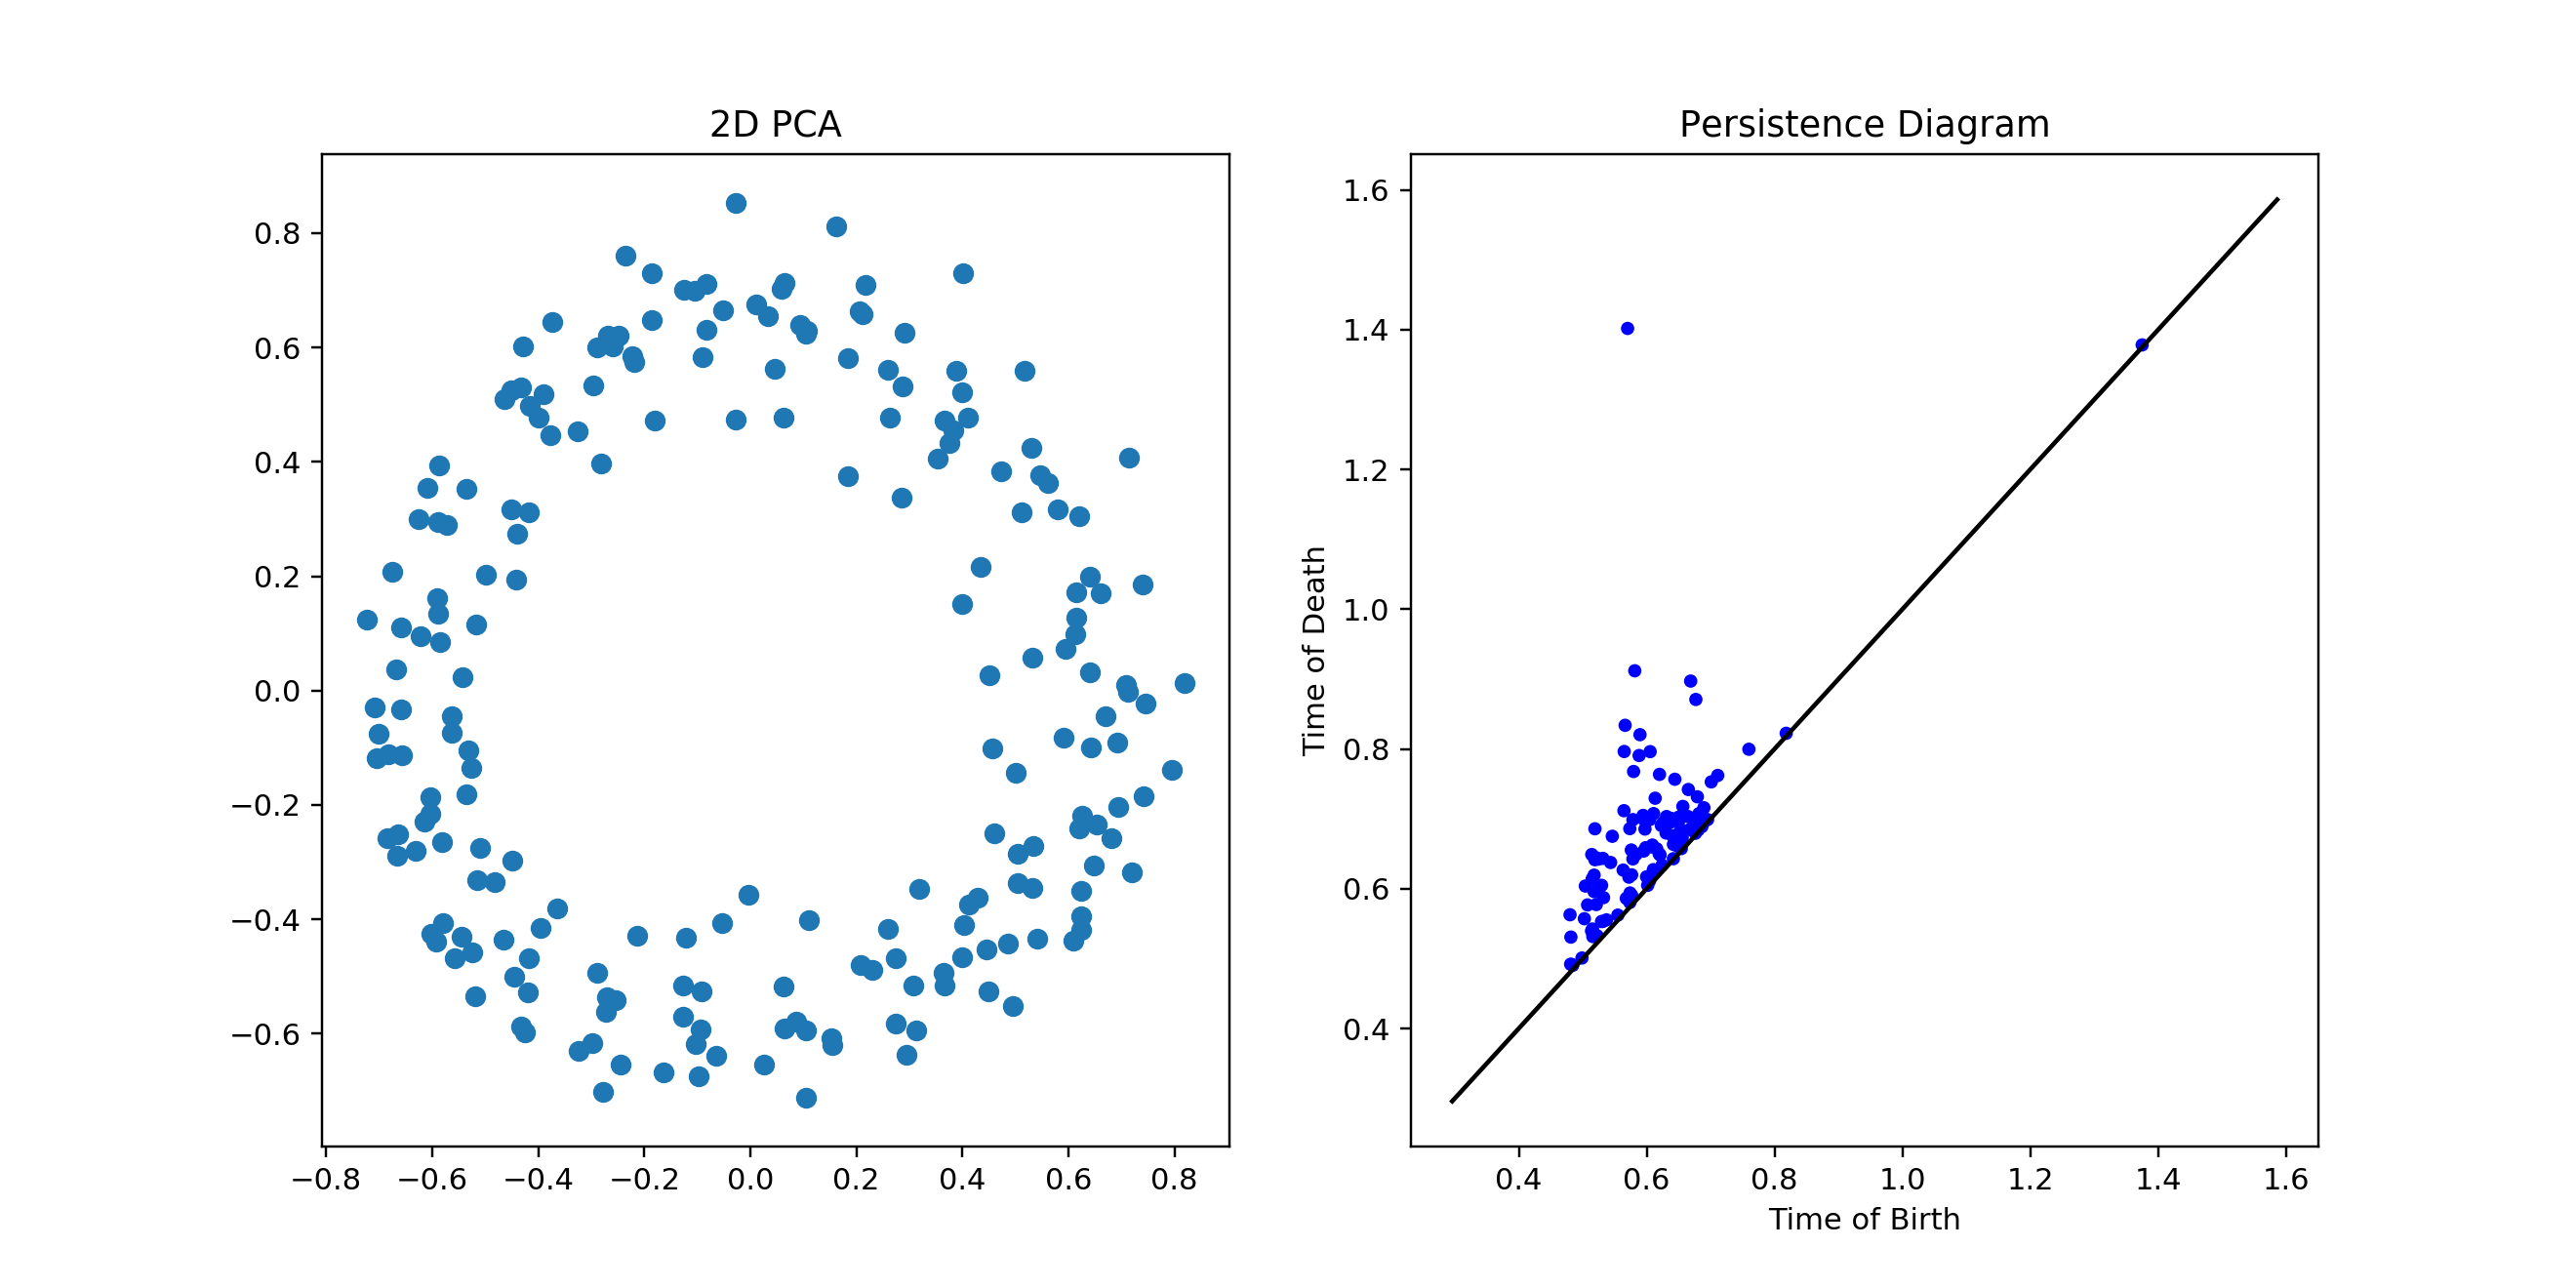

<IPython.core.display.Javascript object>


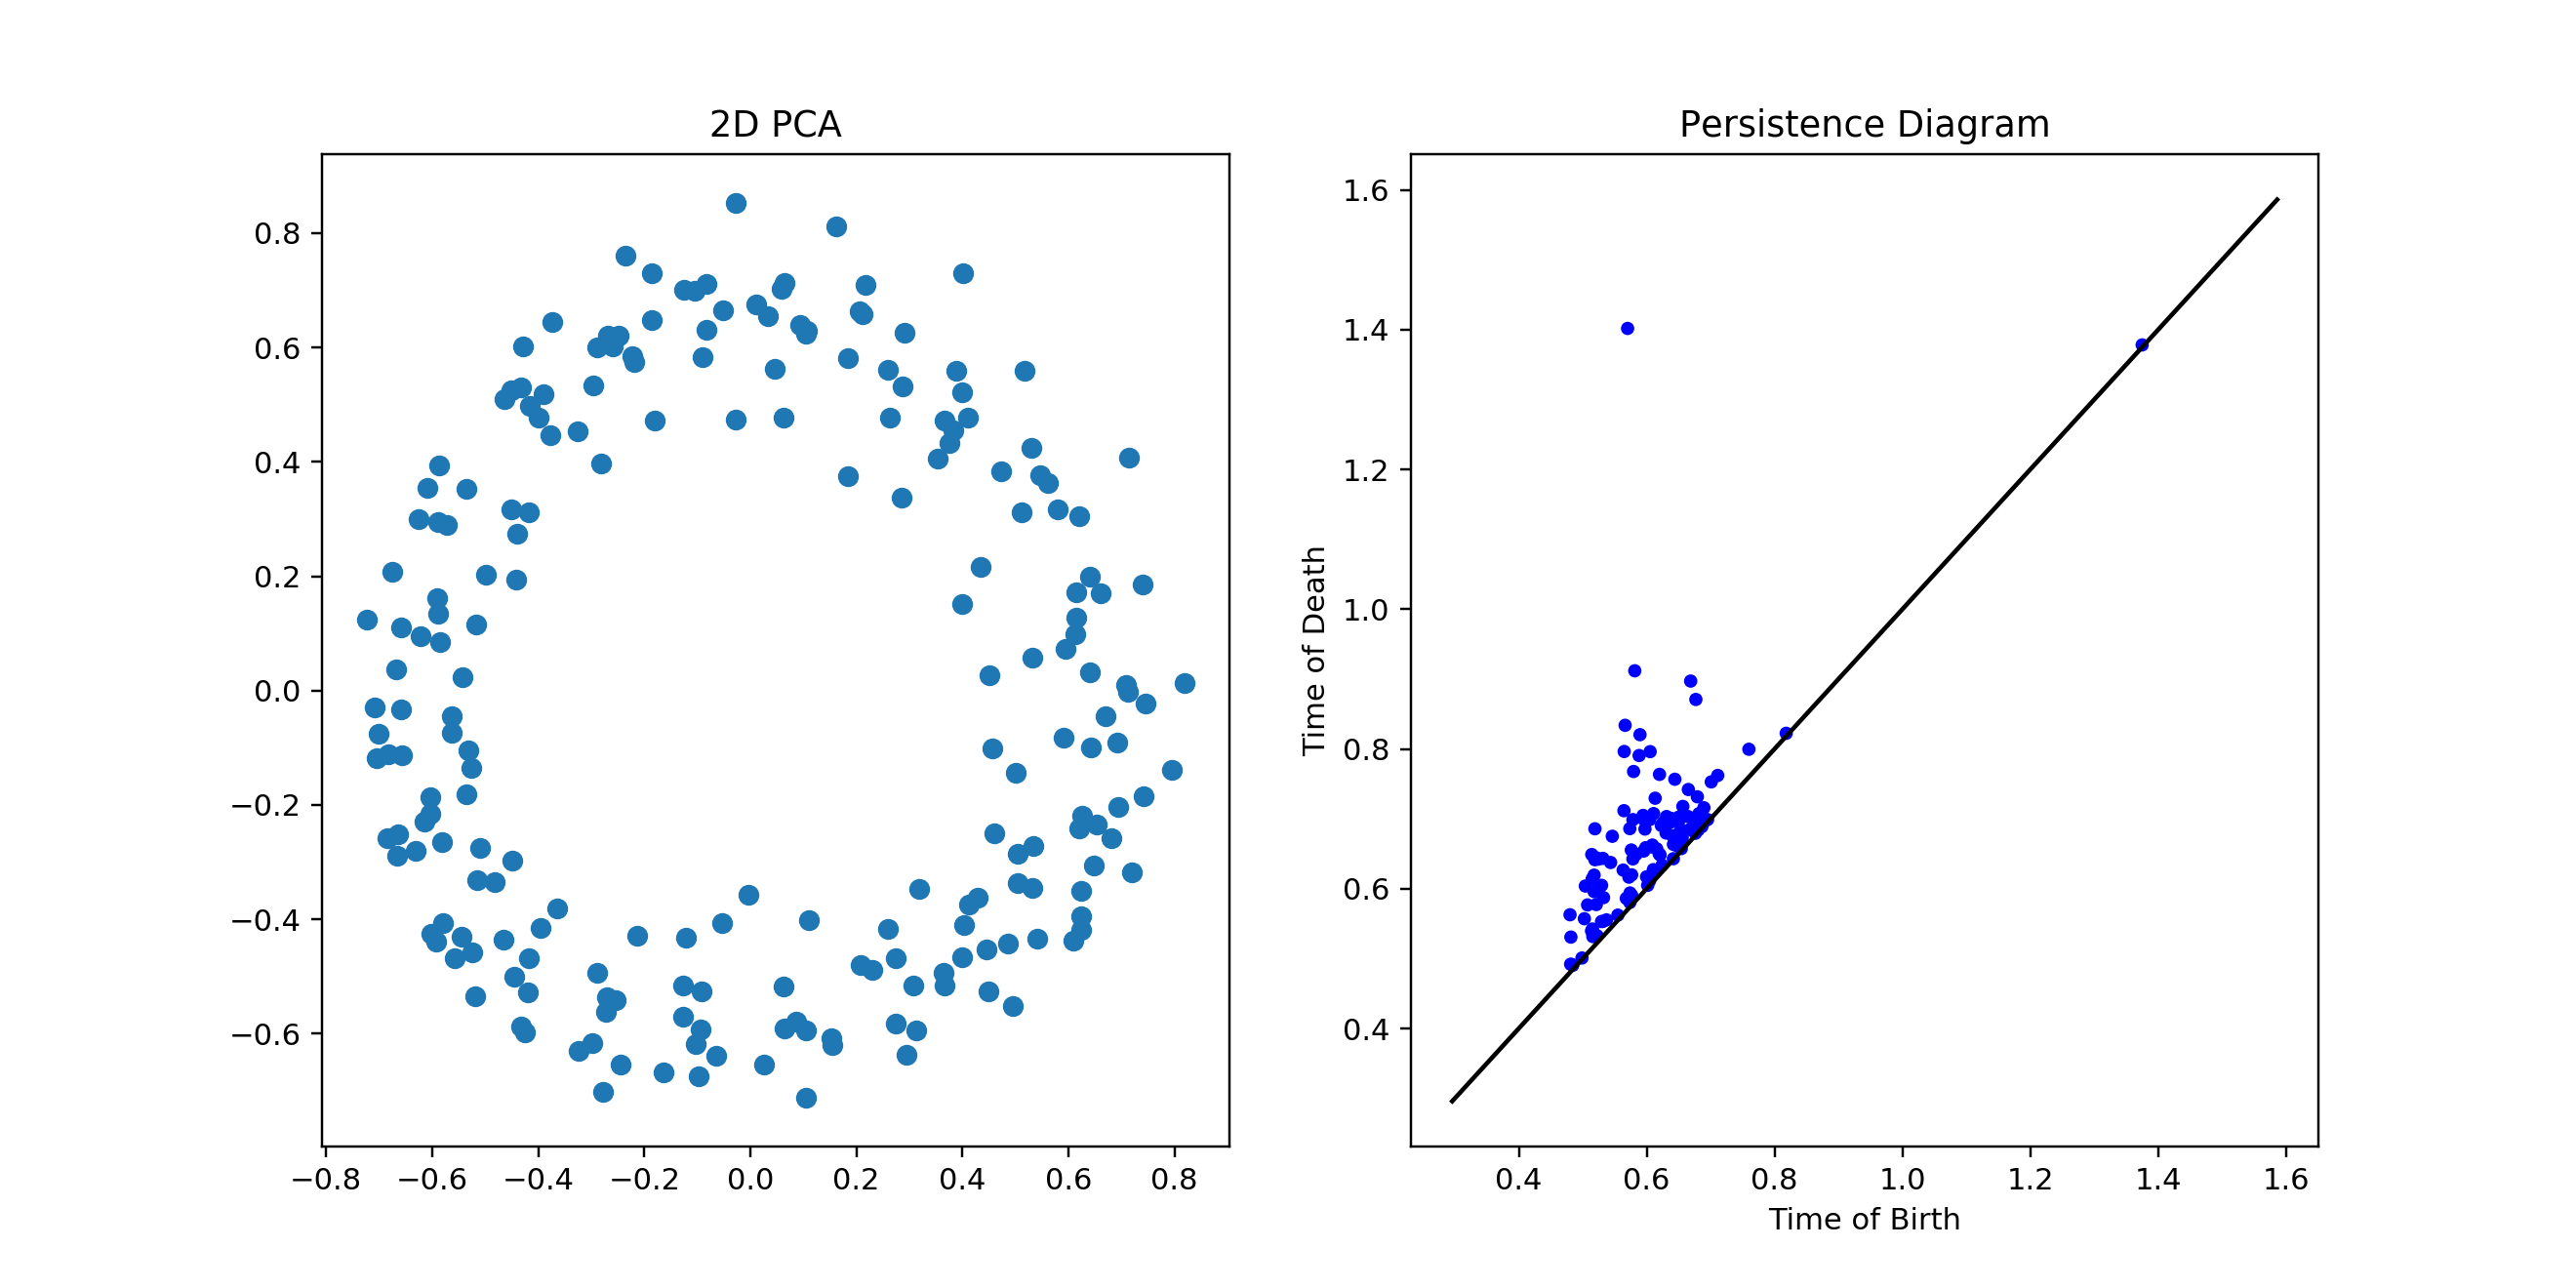

In [12]:
#Get the novelty function for the first three seconds
XNov = librosa.onset.onset_strength(y = X[0:3*Fs], sr = Fs, hop_length = hopSize)
#Make sure the window size is half of a second, noting that
#the audio novelty function has been downsampled by a "hopSize" factor
dim = 20
Tau = (Fs/2)/(float(hopSize)*dim)
dT = 1
Y = getSlidingWindowInteger(XNov, dim, Tau, dT)
print("Y.shape = ", Y.shape)
#Mean-center and normalize
Y = Y - np.mean(Y, 1)[:, None]
Y = Y/np.sqrt(np.sum(Y**2, 1))[:, None]

PDs = doRipsFiltration(Y, 1)
pca = PCA()
Z = pca.fit_transform(Y)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("2D PCA")
plt.scatter(Z[:, 0], Z[:, 1])
plt.subplot(122)
plotDGM(PDs[1])
plt.title("Persistence Diagram")
plt.show()

<h2>Speech Example</h2>
In our final experiment in this module, we will look at a sliding window embedding of the audio novelty function on a speech excerpt which does not have a clear rhythmic structure (courtesy of <a href = "http://marsyasweb.appspot.com/download/data_sets/">http://marsyasweb.appspot.com/download/data_sets/</a>).  Click on the cell below to load the speech audio, and click on the cell below that to run the sliding window embedding + persistent homology

<IPython.core.display.Javascript object>


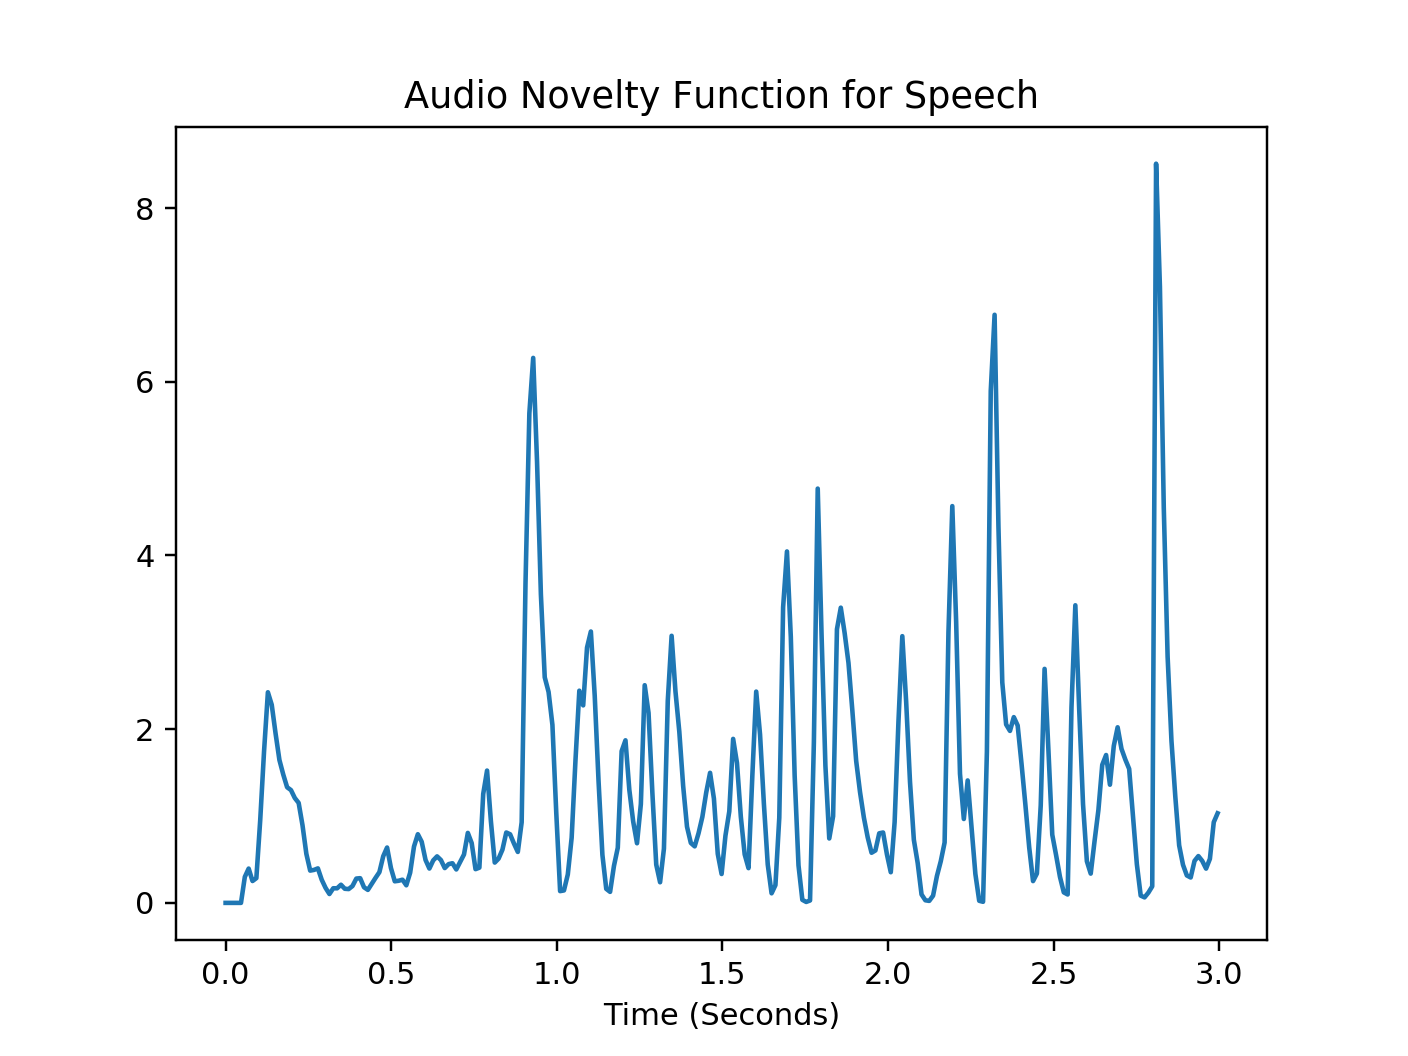

<IPython.core.display.Javascript object>


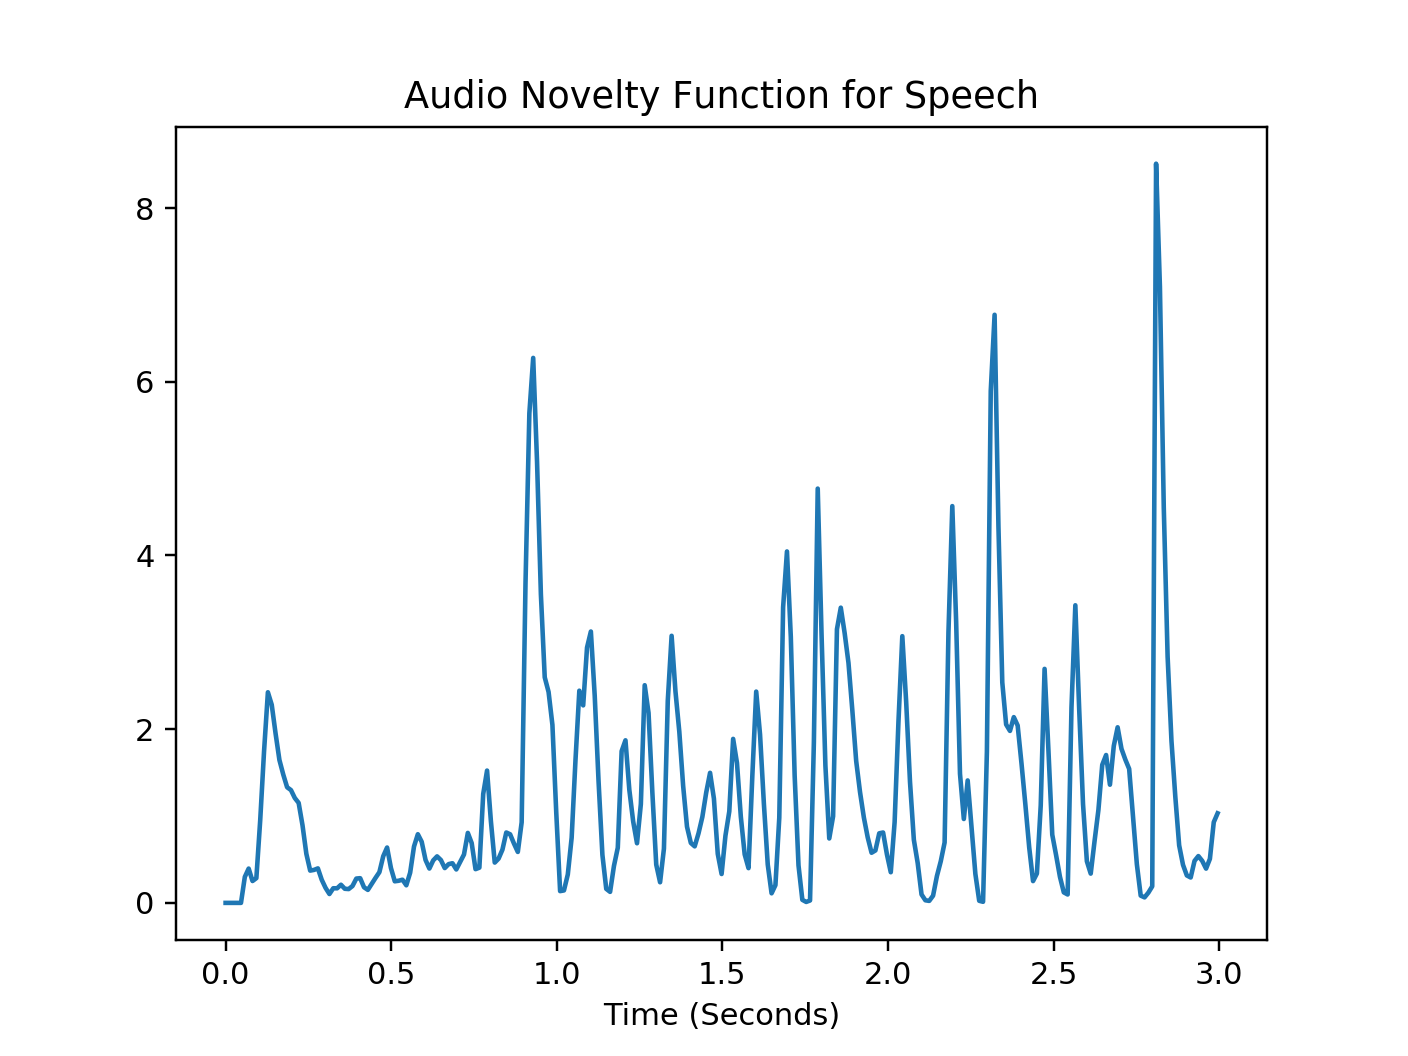

In [13]:
#Read in the audio file.  Fs is the sample rate, and
#X is the audio signal
Fs, X = scipy.io.wavfile.read("speech.wav")
XNov = librosa.onset.onset_strength(y = X[0:3*Fs], sr = Fs, hop_length = hopSize)
plt.figure()
plt.plot(np.arange(len(XNov))*hopSize/float(Fs), XNov)
plt.xlabel("Time (Seconds)")
plt.title("Audio Novelty Function for Speech")
Audio('speech.wav')

Y.shape =  (215, 20)


<IPython.core.display.Javascript object>


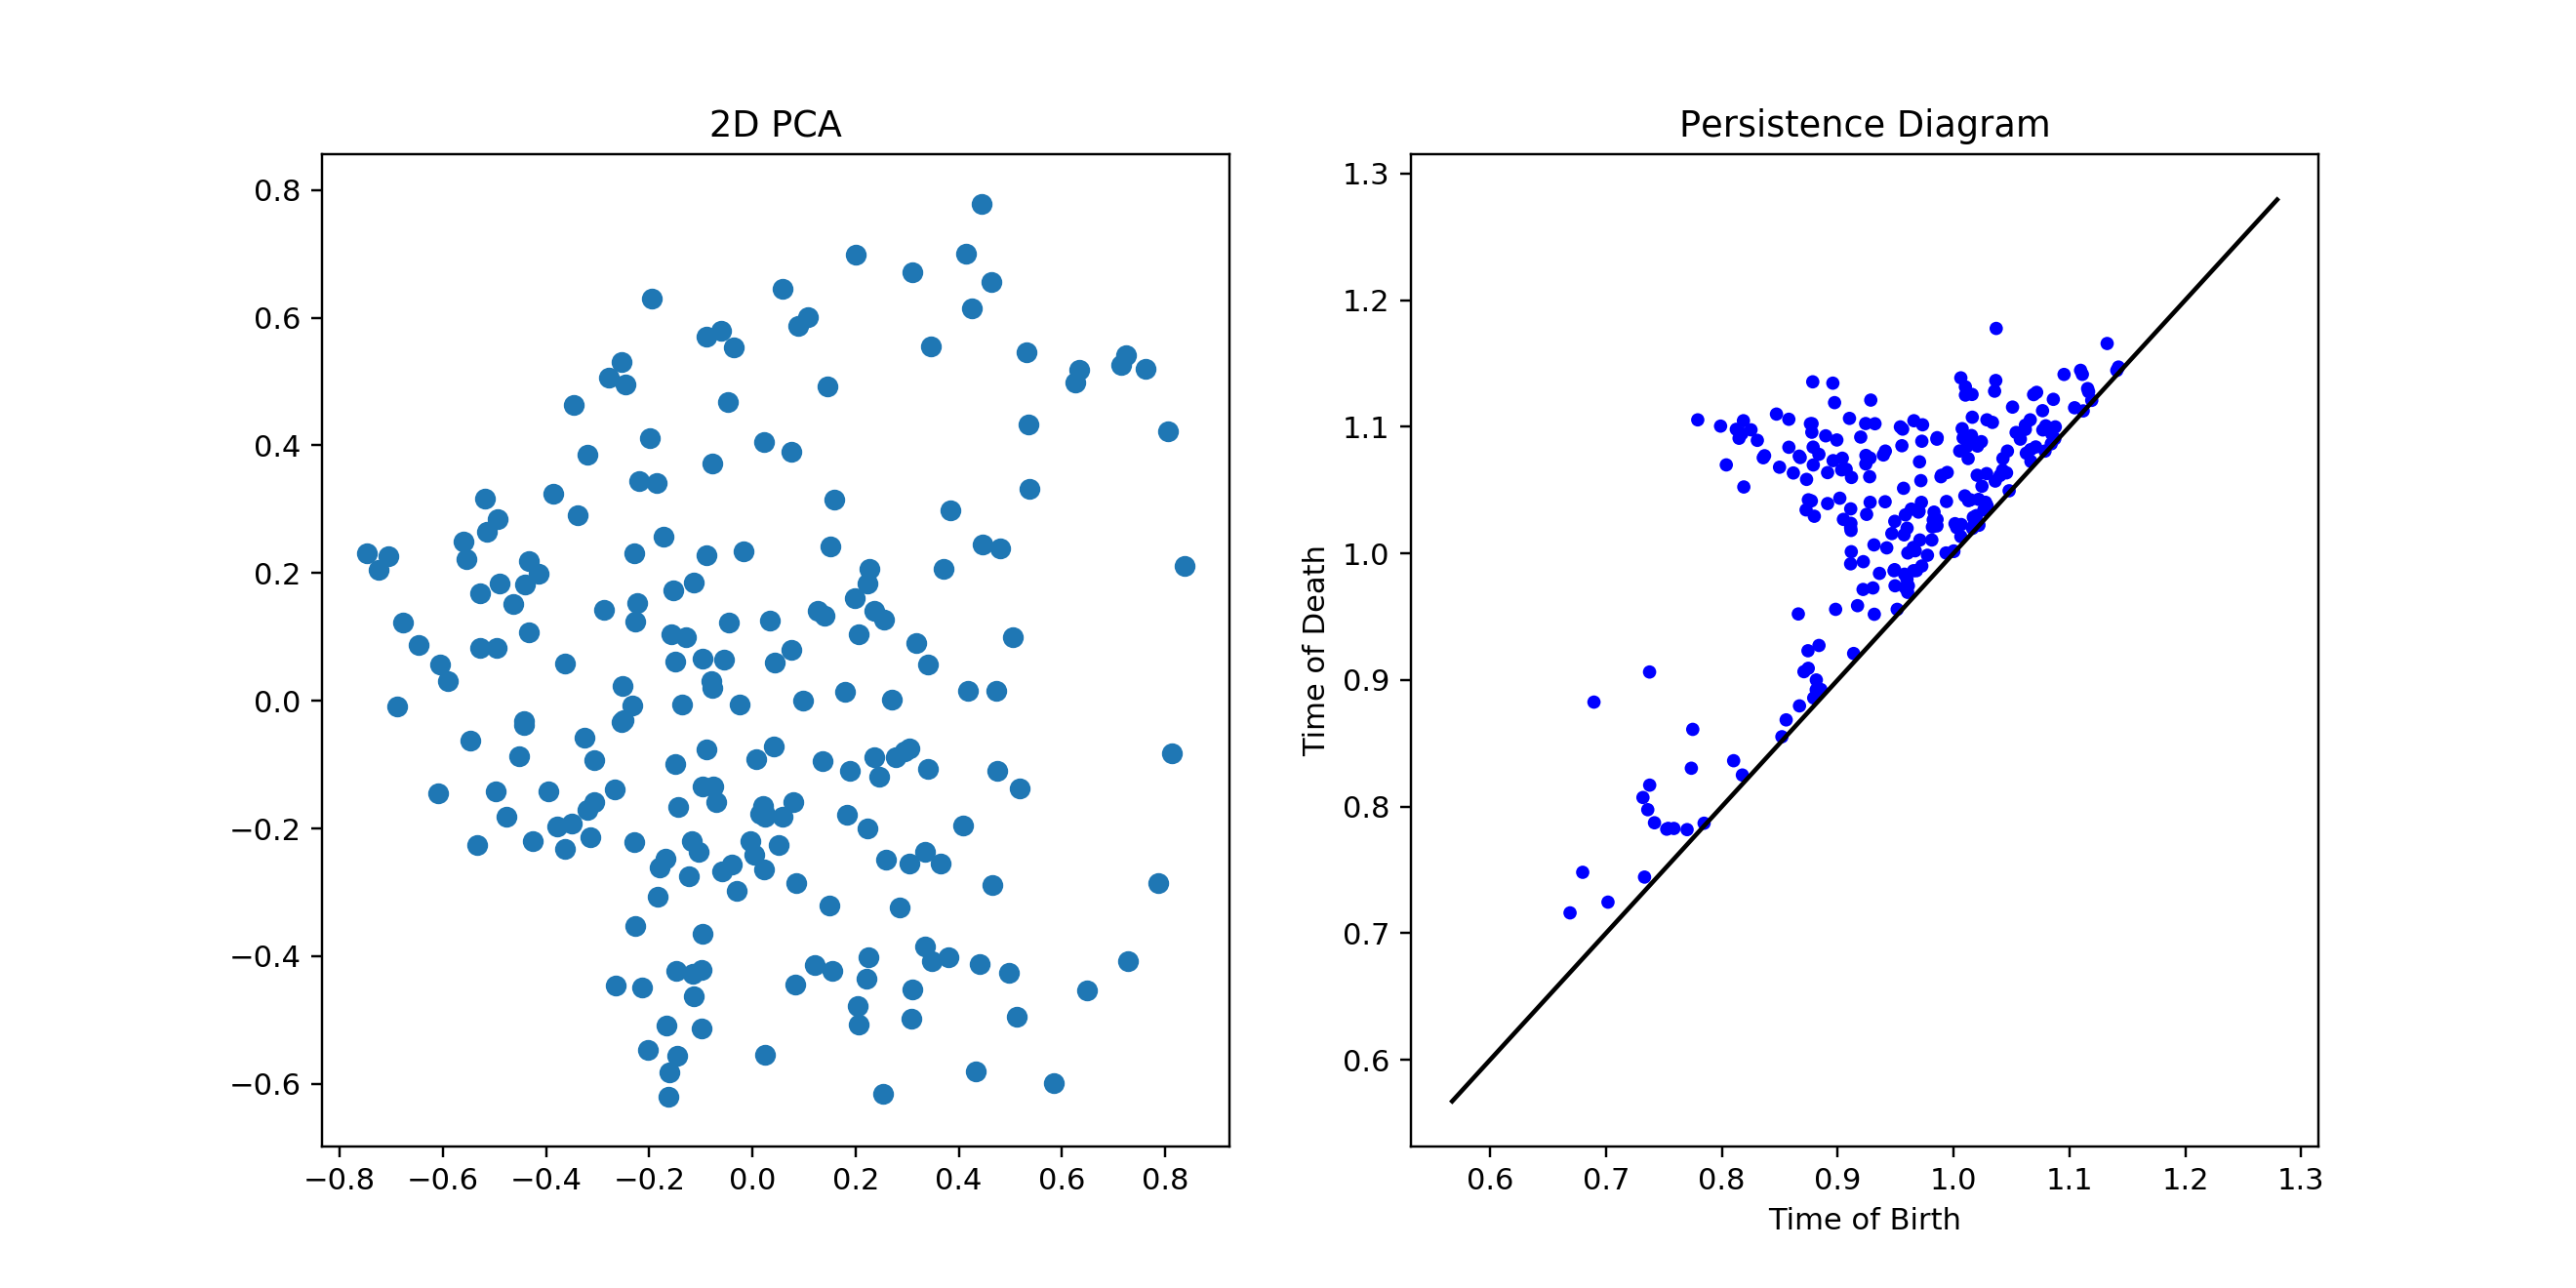

<IPython.core.display.Javascript object>


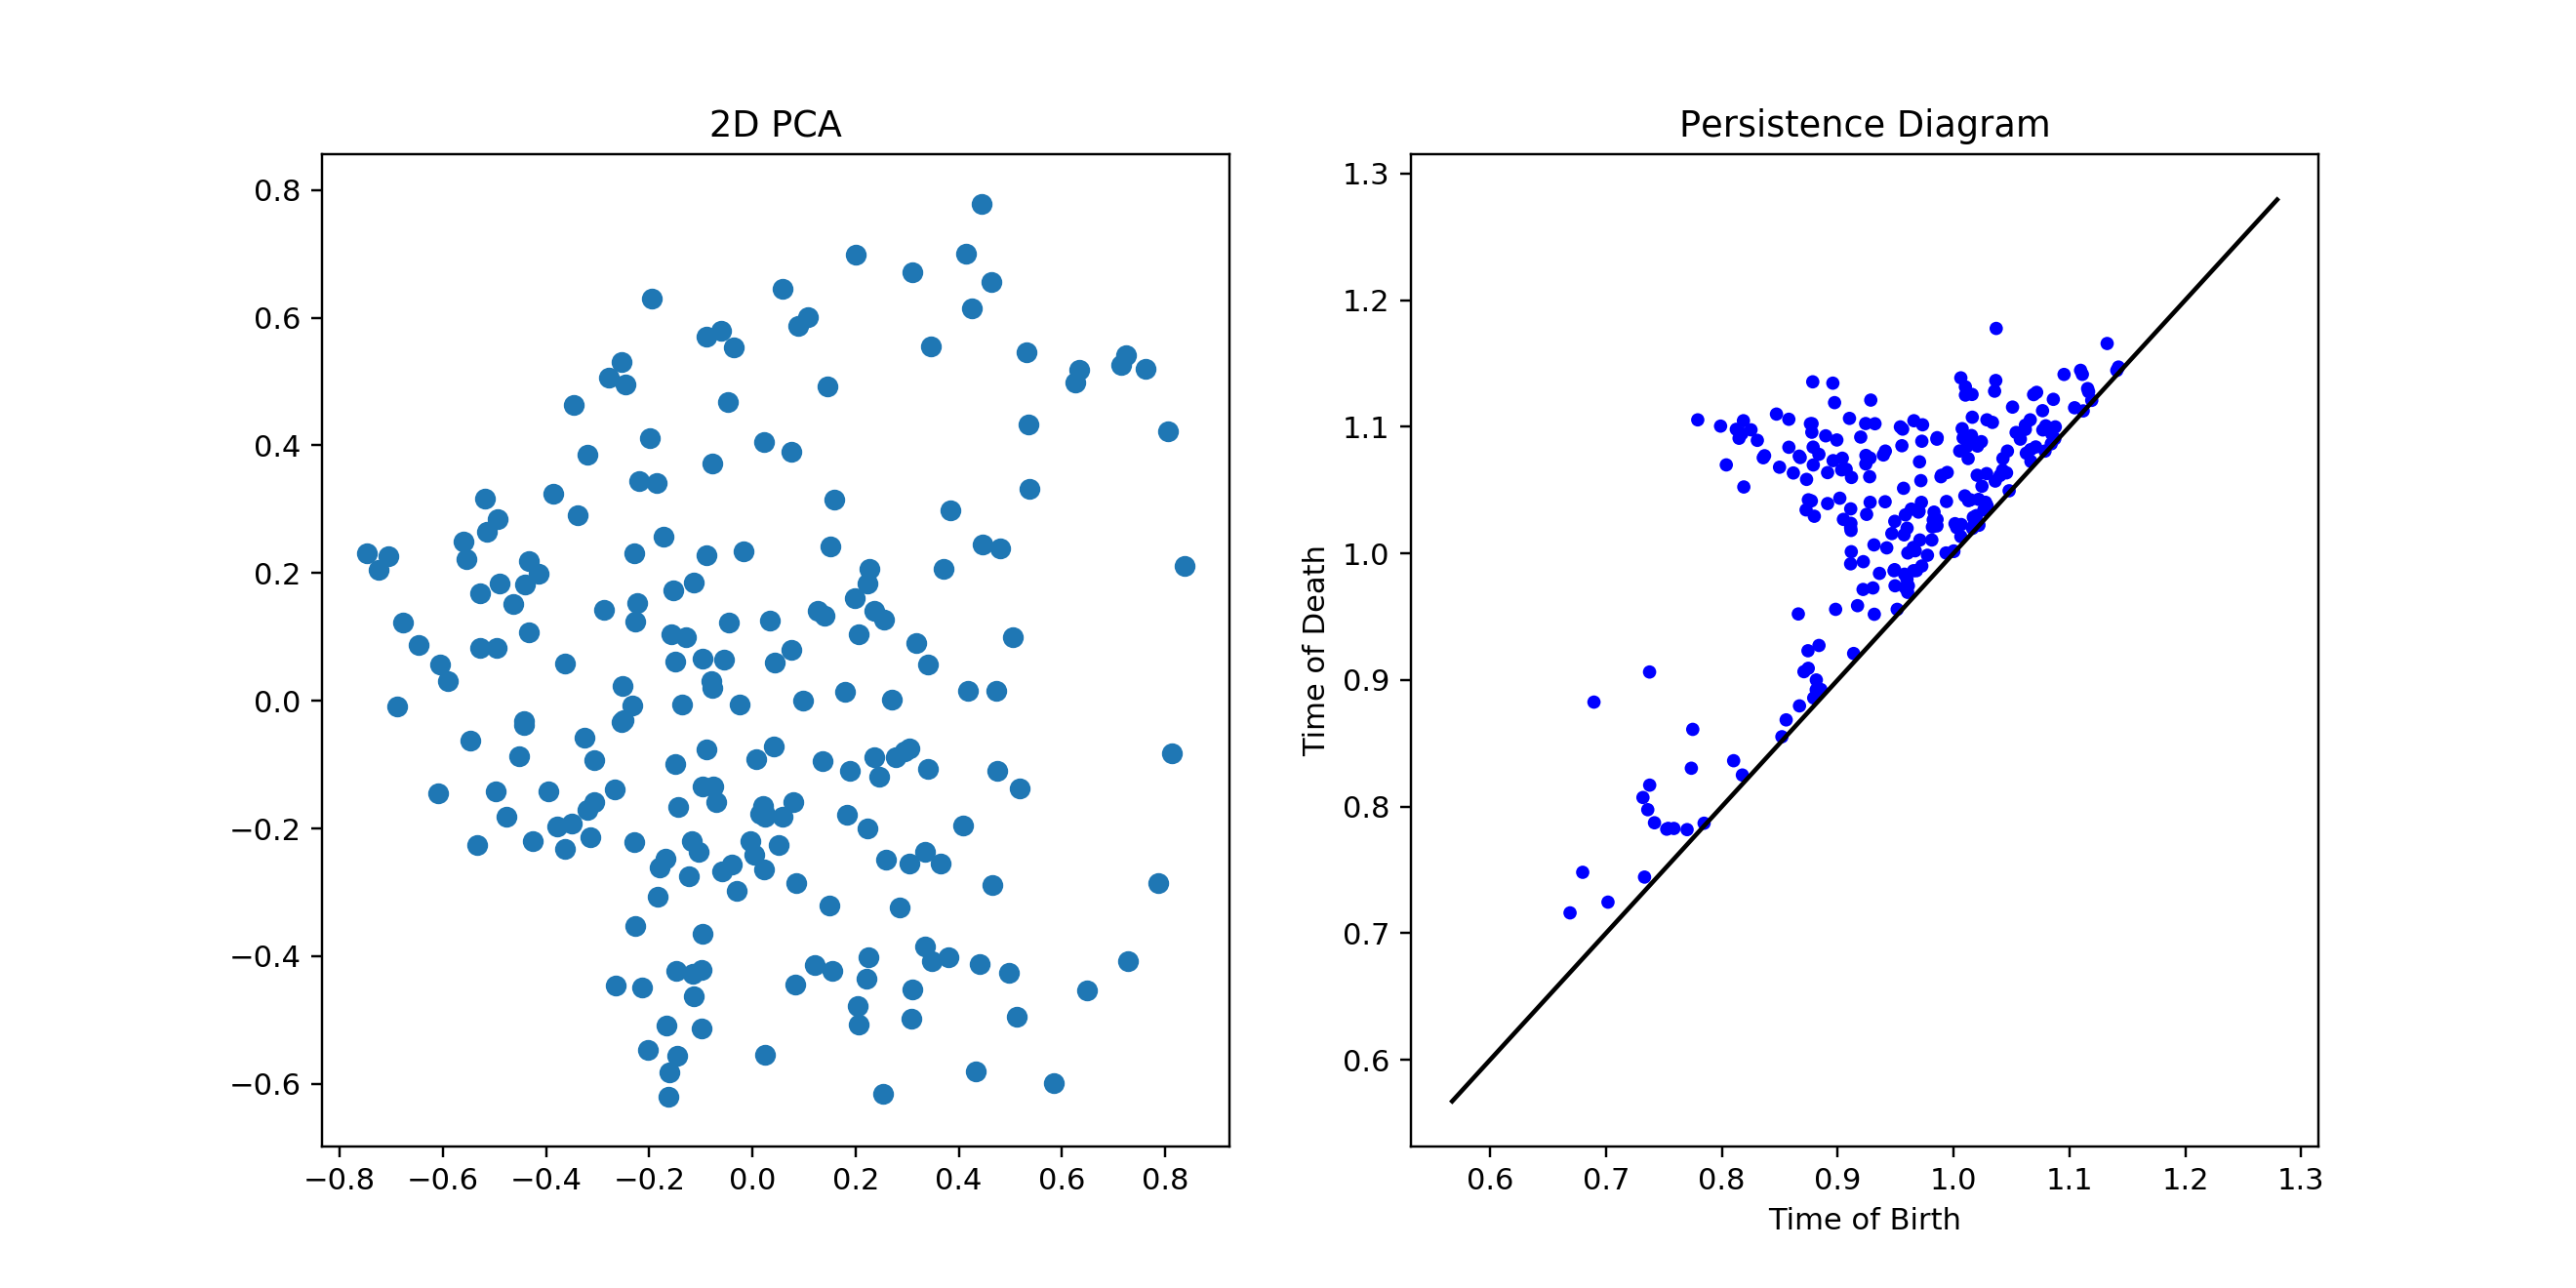

In [14]:
#Get the novelty function for the first three seconds, and use the 
#exact same parameters as before
dim = 20
Tau = (Fs/2)/(float(hopSize)*dim)
dT = 1
Y = getSlidingWindowInteger(XNov, dim, Tau, dT)
print("Y.shape = ", Y.shape)
#Mean-center and normalize
Y = Y - np.mean(Y, 1)[:, None]
Y = Y/np.sqrt(np.sum(Y**2, 1))[:, None]

PDs = doRipsFiltration(Y, 1)
pca = PCA()
Z = pca.fit_transform(Y)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("2D PCA")
plt.scatter(Z[:, 0], Z[:, 1])
plt.subplot(122)
plotDGM(PDs[1])
plt.title("Persistence Diagram")
plt.show()

<h1>Summary</h1>
<ul>
<li>Biphonation is present in nature, for example, in horse whinnies.  In this module we used audio, sampled at 44100hz, to record said whinnies.</li>
<li>Due to noise and other signal artifacts, it is sometimes necessary to search around to find regions of biphonation that are clean enough to be observed via persistent homology</li>
<li>Summary features are often better than raw data in practical scenarios.  In music examples, due to the high sampling rate of audio and the messy signal, it is often advantageous to compute summary signals at a lower temporal resolution when analyzing rhythm periodicities.</li>
<li>After the proper preprocessing, TDA on sliding window embeddings can pick up on the presence of rhythmic periodicities in music.</li>
</ul>